In [45]:
# Explore the columns of data and find outliers
import pandas as pd
import numpy as np
import os
import datetime
from typing import List, Tuple, Dict, Any, Union, Callable

import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles

plt.rcParams.update(bundles.beamer_moml())

# Dataset Loading & Preprocess

This section loads the datasets that will be used for exploration into the RAM.
- `charts_df` is responsible for the rankings of the songs of different days and regions
- `audio_df` is responsible for the audio features, which are fetched by using Spotify API in the `data_preprocess.ipynb` notebook.

In [8]:
CHARTS_PATH = '../../data/charts_processed.csv'

# Load the datasets into dataframes
charts_df = pd.read_csv(CHARTS_PATH)

# Convert the date column to datetime.date
charts_df['date'] = charts_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
charts_df.head()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0


In [9]:
# Load the audio features dataset
AUDIO_PATH = '../../data/audio_features_processed.csv'
audio_df = pd.read_csv(AUDIO_PATH)

# Change the column-name of 'id' to 'track_id' to match the charts_df
audio_df.rename(columns={'id': 'track_id'}, inplace=True)
audio_df.head()


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,track_id
0,0.18700,0.852,195840,0.773,0.000030,8,0.1590,-2.921,0,0.0776,102.034,4,0.907,6mICuAdrwEjh6Y6lroV2Kg
1,0.00431,0.663,259196,0.920,0.000017,11,0.1010,-4.070,0,0.2260,99.935,4,0.533,7DM4BPaS7uofFul3ywMe46
2,0.40000,0.761,222560,0.838,0.000000,4,0.1760,-3.073,0,0.0502,93.974,4,0.710,3AEZUABDXNtecAOSC1qTfo
3,0.55100,0.508,205600,0.687,0.000003,0,0.1260,-4.361,1,0.3260,180.044,4,0.555,6rQSrBHf7HlZjtcMZ4S4bO
4,0.07600,0.899,234320,0.626,0.000000,6,0.0631,-4.228,0,0.2920,88.007,4,0.873,58IL315gMSTD37DOZPJ2hf


In [10]:
# For now only restrict the dataset to top200 charts for stream/ranking analysis.
charts_df = charts_df[charts_df["chart"] == "top200"]

charts_df["track_id"] = charts_df["url"].apply(lambda x: x.split("/")[-1])

# Utility Functions
This section defines some necessary functions for the operations of dataset.

In [47]:
def get_charts_by_date(df : pd.DataFrame, date : Union[str, Tuple[str,str]]) -> pd.DataFrame:
    """
    Get the elements of the dataframe that match the date.
    If date is a tuple, return the elements between the two dates.

    Parameters:
        df (pd.DataFrame): The dataframe to filter
        date (str or tuple): The date or the tuple of dates to filter the dataframe

    Returns:
        pd.DataFrame: The filtered dataframe
    """
    if isinstance(date,tuple):
        return df[(df['date'] >= date[0]) & (df['date'] <= date[1])]
    else:
        return df[df['date'] == date]

def get_charts_by_region(df : pd.DataFrame, region : Union[str, List[str]]) -> pd.DataFrame:
    """
    Return the charts by region.
    If region is a list, return the charts for the regions in the list.

    Parameters:
        df (pd.DataFrame): The dataframe to filter
        region (str or list): The region or the list of regions to filter the dataframe

    Returns:
        pd.DataFrame: The filtered dataframe
    """
    if isinstance(region, list):
        return df[df['region'].isin(region)]
    return df[df['region'] == region]

def get_regional_weekly_charts_ranking(df : pd.DataFrame, date : Union[str, Tuple[str,str]], operation : str = 'sum', normalize_streams : bool = True) -> pd.DataFrame:
    """
    Transform daily data into weekly data. Rearange the rankings by getting the mean of streams and assigning a
    new ranking based on the mean. 

    Parameters:
        df (pd.DataFrame): The dataframe to filter. Should be the charts dataframe
        date (str or tuple): The date or the tuple of dates to filter the dataframe
        operation (str): The operation to perform on the streams. Either 'mean' or 'sum'

    Returns:
        pd.DataFrame: The filtered dataframe
    """
    # This should be a view and should not change the original df
    df = df.copy()
    df = get_charts_by_date(df, date)

    if operation == 'mean':
        df_group = df.groupby(['track_id']).mean().reset_index()
    elif operation == 'sum':
        df_group = df.groupby(['track_id']).sum().reset_index()
    else:
        raise ValueError("Operation should be either 'mean' or 'sum'")
    
    # Sort the tracks by streams to get the rankings
    df_group = df_group.sort_values(by=['streams'], ascending=False).reset_index()

    # Assign the new rankings
    df_group['rank'] = df_group.index + 1

    # Merge the two dataframes so that df_group also include title, artist, region
    df_group = df_group.merge(df[['track_id', 'title', 'artist', 'region']], on='track_id', how='left')

    # Remove duplicates will look same after we merge the two dataframes
    df_group = df_group.drop_duplicates(subset=['track_id'])

    df_group["start_date"] = date[0] if isinstance(date,tuple) else date
    df_group["end_date"] = date[1] if isinstance(date,tuple) else date

    # Normalize the streams between 0 and 1
    if normalize_streams:
        df_group['streams'] = (df_group['streams'] - df_group['streams'].min()) / (df_group['streams'].max() - df_group['streams'].min())

    return df_group

In [48]:
# An example of getting monthly charts for Turkey
turkey_df = get_charts_by_region(charts_df, 'Turkey')
get_regional_weekly_charts_ranking(turkey_df, (datetime.datetime(2018,1,1).date(), datetime.datetime(2018,1,30).date()), normalize_streams=True)

,index,track_id,rank,streams,title,artist,region,start_date,end_date
0,80,2BJkinM7TmdcsDGNvmZds8,1,1.000000,Yanıyoruz,Burak King,Turkey,2018-01-01,2018-01-30
30,184,4sa0pXDdQkBZ1r5NZWQJyV,2,0.820904,Heyecanı Yok,Gazapizm,Turkey,2018-01-01,2018-01-30
60,209,5dLtu0lS5pP9ivMerk3uMA,3,0.680481,Gömün Beni Çukura,Eypio,Turkey,2018-01-01,2018-01-30
90,282,7wGoVu4Dady5GV0Sv4UIsx,4,0.641033,rockstar,"Post Malone, 21 Savage",Turkey,2018-01-01,2018-01-30
120,203,5Y3ZTBwRNrgj3AlXYASvDe,5,0.600484,İmkansızım,Ezhel,Turkey,2018-01-01,2018-01-30
...,...,...,...,...,...,...,...,...,...
5995,263,7E7SO2gZLbJK4CMUuPEOYZ,279,0.000333,Aşkın Kenarından,MFÖ,Turkey,2018-01-01,2018-01-30
5996,226,62uCtBhwVAyiw6ip557d49,280,0.000298,Unut Beni,Gece Yolcuları,Turkey,2018-01-01,2018-01-30
5997,149,3m660poUr1chesgkkjQM7P,281,0.000100,Sorry Not Sorry,Demi Lovato,Turkey,2018-01-01,2018-01-30
5998,124,3A7qX2QjDlPnazUsRk5y0M,282,0.000042,2U (feat. Justin Bieber),David Guetta,Turkey,2018-01-01,2018-01-30


In [18]:
import plotly.express as px

num_of_regional_points = charts_df.groupby('region').count().iloc[:,0]


fig = px.choropleth(num_of_regional_points, 
                    locations=num_of_regional_points.index, 
                    color=num_of_regional_points.values,
                    locationmode='country names',
                    color_continuous_scale='Blues',
                    title="Number of regional points")
fig.show()


# Audio Feature Analysis

In [49]:
def datetime_start_end_generator(start_date, end_date, delta : int = 7):
    """
    Generate datetime.date objects between start_date and end_date specified with delta days
    """
    curr_date = start_date

    # Transform the delta into a datetime.timedelta object
    delta = datetime.timedelta(days=delta)
    
    while curr_date <= end_date:
        yield (curr_date, curr_date + delta)
        curr_date += delta + datetime.timedelta(days=1)

def regional_trends(df, region, start_date, end_date, delta : int = 7, normalize_streams : bool = True):
    """
    Get the regional trends for a region between start_date and end_date with delta days
    """
    # Get the start and end dates

    if not isinstance(start_date, datetime.date):    
        start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date()
        end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d').date()
        
    
    # First get the date range between start_date and end_date to restrict the data
    df = get_charts_by_date(df, (start_date, end_date))
    
    # Generate the start and end dates
    dates = datetime_start_end_generator(start_date, end_date, delta)
    
    # Get the regional weekly charts ranking for each date
    region_df = get_charts_by_region(df, region)
    df_list = [get_regional_weekly_charts_ranking(region_df, date, normalize_streams = normalize_streams) for date in dates]
    
    # Return the df_list and start-end date pairs
    return df_list, [(df["start_date"].iloc[0], df["end_date"].iloc[0]) for df in df_list]

In [59]:
interest_columns = ["danceability", "energy", "speechiness", "instrumentalness", "liveness", "valence"]

def add_audio_features(df, audio_df):
    """
    Add audio features to the dataframe
    """
    # Merge the two dataframes

    df = df.merge(audio_df, on='track_id', how='left')
    
    return df

def get_mean_audio_features(df, feature_columns):
    """
    Get the mean of audio features for each track
    """
    # Get the mean of the all songs in the dataframe
    return df[feature_columns].mean()

# Get the regional trends for Germany
weekly_trends,dates = regional_trends(charts_df, "Germany", "2018-01-01", "2019-01-01", delta=7)
weekly_trends_features = [add_audio_features(df, audio_df) for df in weekly_trends]

/var/folders/ml/xqpw1bd16gx6lwbbzz68kl_c0000gn/T/ipykernel_92541/1186261831.py:18: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/var/folders/ml/xqpw1bd16gx6lwbbzz68kl_c0000gn/T/ipykernel_92541/757781685.py:29: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 

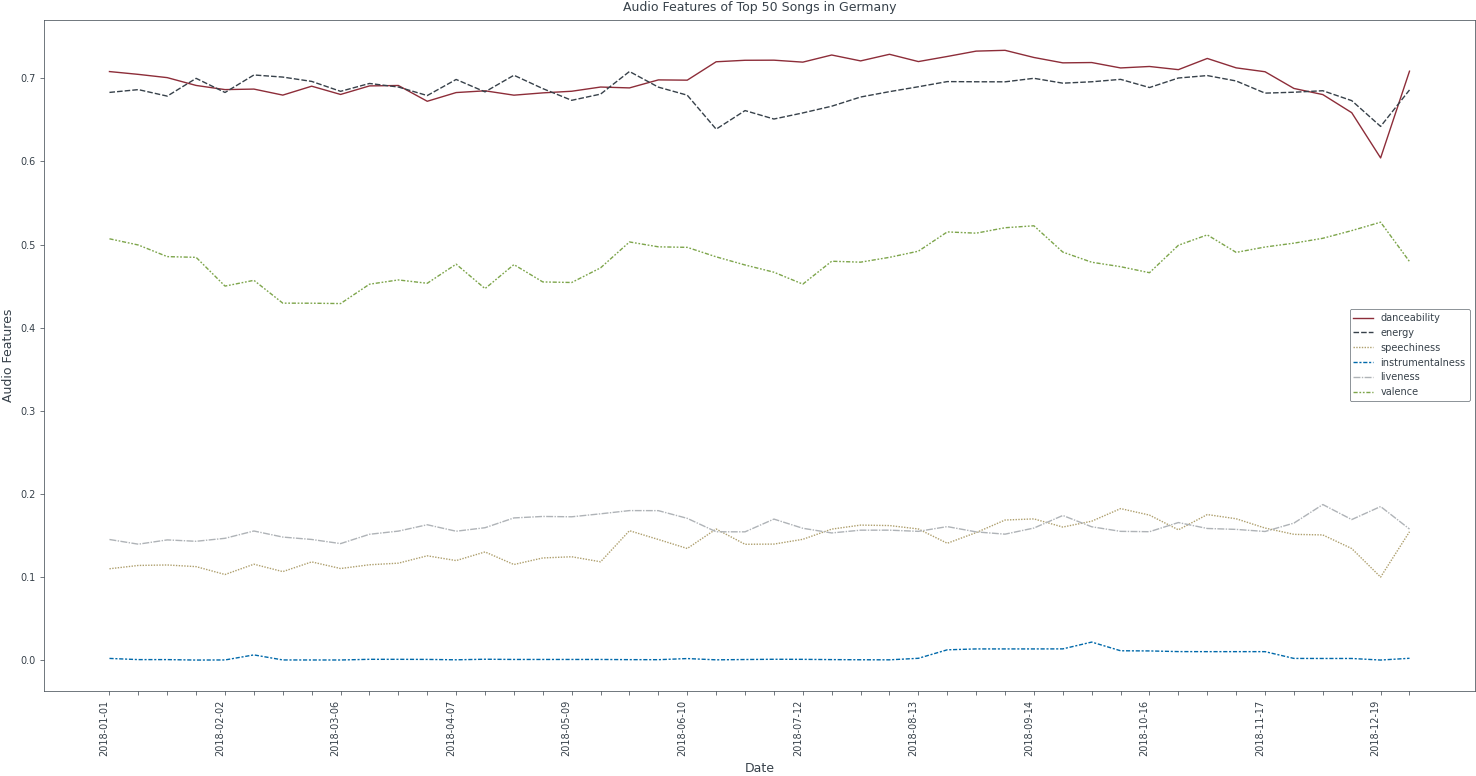

In [60]:

# Average over the weeks to get the mean audio features per week
weekly_trends_top_50 = [get_mean_audio_features(df.iloc[:50], audio_df.columns[1:]) for df in weekly_trends_features]

# Convert datetime object to string
dates_str = [str(date[0]) for date in dates]

# Create a dataframe for each audio feature
weekly_trends_top_50_df = pd.DataFrame(weekly_trends_top_50, index=dates_str)

# Create a subplot with 3 rows and 1 column
fig, axes = plt.subplots(1, 1, figsize=(15, 8))

if not isinstance(axes,list):
    axes = [axes]
    
# Plotting the data
sns.lineplot(data=weekly_trends_top_50_df[interest_columns], ax=axes[0])

# Set the labels for each subplot

plt.title("Audio Features of Top 50 Songs in Germany")

axes[0].set_ylabel("Audio Features")
# Clear the x-labels for the top and middle subplots
axes[0].set_xlabel("Date")

# Rotate the x-tick labels for readability and only include some of them
for i,ax in enumerate(axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

# For every 4 weeks, only show the label of the first week in x-axis
for i,ax in enumerate(axes):
    for j,label in enumerate(ax.xaxis.get_ticklabels()):
        if j % 4 != 0:
            label.set_visible(False)
    

# Adjust the layout for a cleaner look
plt.tight_layout()

# Display the plot
plt.show()



findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

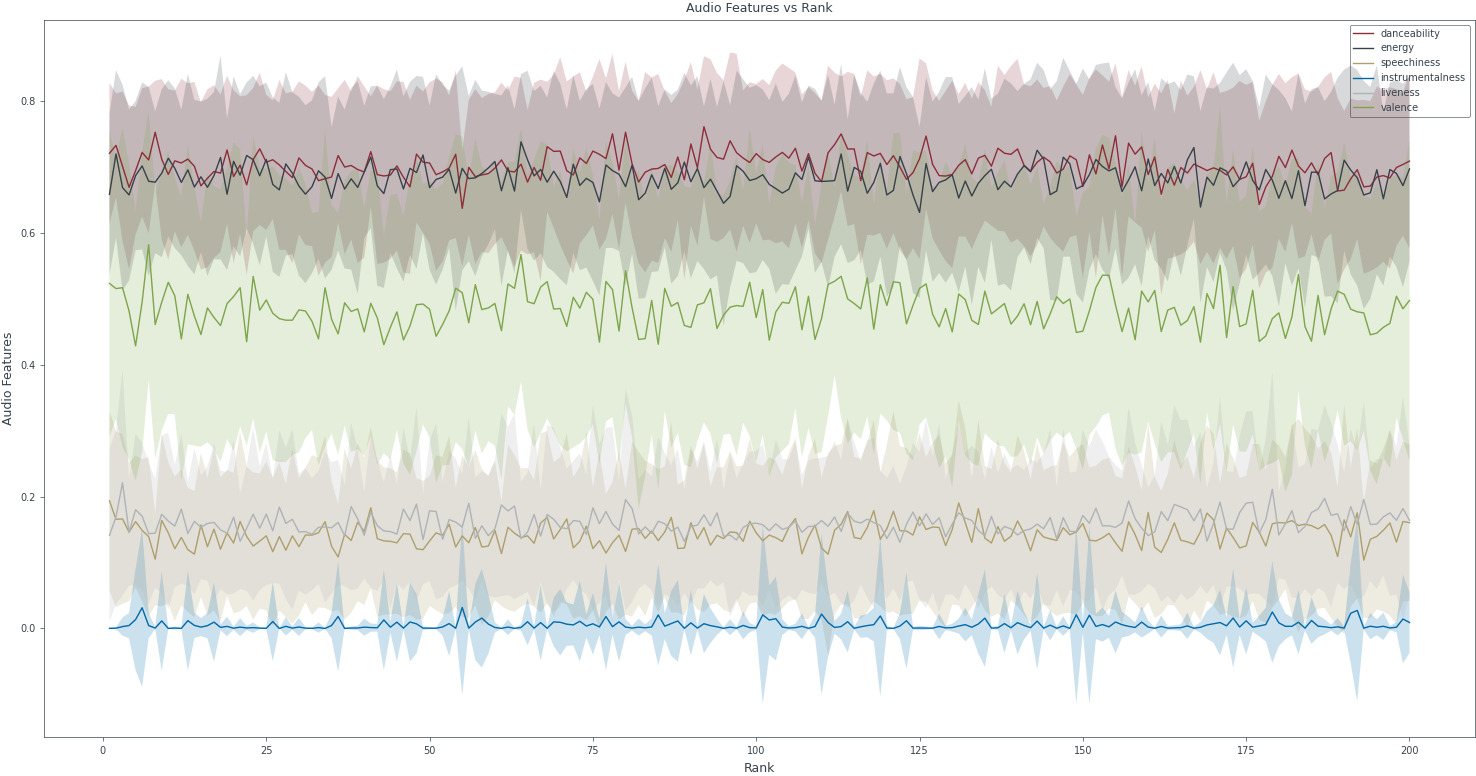

In [61]:
def plot_audio_features_vs_rank(df, feature_columns, rank_column="rank"):
    """
    Given list of dataframes each seperated with respect to date, plot the audio features vs rank
    Calculate the mean and standard deviation of the audio features for each rank and plot them
    """
    df = pd.concat(df)

    # Get the mean of audio features for each rank
    df_mean = df.groupby(rank_column).mean().reset_index()
    
    # Get the standard deviation of audio features for each rank
    df_std = df.groupby(rank_column).std().reset_index()
    
    # Plot the audio features vs rank
    fig, axes = plt.subplots(1, 1, figsize=(15, 8))
    
    if not isinstance(axes,list):
        axes = [axes]
    
    # Plot the mean and fill the area between mean + std and mean - std
    for feature in feature_columns:
        axes[0].plot(df_mean[rank_column], df_mean[feature], label=feature)
        axes[0].fill_between(df_mean[rank_column], df_mean[feature] - df_std[feature], df_mean[feature] + df_std[feature], alpha=0.2)
    
    plt.title("Audio Features vs Rank")
    axes[0].set_ylabel("Audio Features")
    axes[0].set_xlabel("Rank")
    
    # Adjust the layout for a cleaner look
    plt.tight_layout()
     
    # Show legend
    plt.legend()

    # Display the plot
    plt.show()

# Only get the top 200 songs
plot_audio_features_vs_rank([df.iloc[:200] for df in weekly_trends_features], interest_columns)


# Popularity vs Audio Feature


In [125]:
def regional_delta_popularity(df, start_date, end_date, delta : int = 7, top_k : int = 200):
    """
    For a dataframe, for a delta days, measure how many days a track is in the top 200 charts.
    This can be done by grouping by track_id and counting the number of rows between start_date and end_date.
    """

    dates = datetime_start_end_generator(start_date, end_date, delta)

    df_list = []
    for date in dates:
        df_date = get_charts_by_date(df, date)
        
        # Groupby track_id and count the number of rows. 
        df_top_k_ranks = df_date[df_date["rank"] <= top_k].copy()

        df_popularity = df_top_k_ranks.groupby(['track_id']).count().reset_index()
        df_popularity = df_popularity[["track_id", "rank"]]

        not_in_top_k = df_date[~df_date["track_id"].isin(df_popularity["track_id"])]

        # Add 0 for the tracks that are not in the top k
        df_popularity = df_popularity.append(pd.DataFrame({"track_id": not_in_top_k["track_id"], "rank": 0}))

        # Rename the rank column to popularity
        df_popularity.rename(columns={"rank": "popularity"}, inplace=True)

        # Join the two dataframes
        df_date = df_date.merge(df_popularity, on='track_id', how='left')

        # Use the values in df_group to create new popularity column
        df_date = df_date.drop_duplicates(subset=['track_id'])

        # Add the start and end dates
        df_date["start_date"] = date[0] if isinstance(date,tuple) else date
        df_date["end_date"] = date[1] if isinstance(date,tuple) else date

        df_list += [df_date]
        break

    return df_list, [(df["start_date"].iloc[0], df["end_date"].iloc[0]) for df in df_list]

turkey_df = get_charts_by_region(charts_df, 'Turkey')
df_test, dates_test = regional_delta_popularity(turkey_df, datetime.datetime(2018,1,1).date(), datetime.datetime(2018,1,30).date(), delta=6, top_k=100)

# Write a simple test. Check if for each date range, the "popularity" column equals to the number of days in the top 100
for df in df_test:
    df_test_date = get_charts_by_date(turkey_df, (df["start_date"].iloc[0], df["end_date"].iloc[0]))

    # For each track id in the df_test_date, check if the popularity column equals to the number of days in the top 100
    for track_id in df_test_date["track_id"].unique():
        df_track_id = df_test_date[df_test_date["track_id"] == track_id]
        assert df[df["track_id"] == track_id]["popularity"].values[0] == df_track_id[df_track_id["rank"] <= 100].shape[0], f'{df[df["track_id"] == track_id]["popularity"].values[0]} != {df_track_id[df_track_id["rank"] <= 100].shape[0]}'

/var/folders/ml/xqpw1bd16gx6lwbbzz68kl_c0000gn/T/ipykernel_92541/4215910598.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/var/folders/ml/xqpw1bd16gx6lwbbzz68kl_c0000gn/T/ipykernel_92541/4215910598.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families

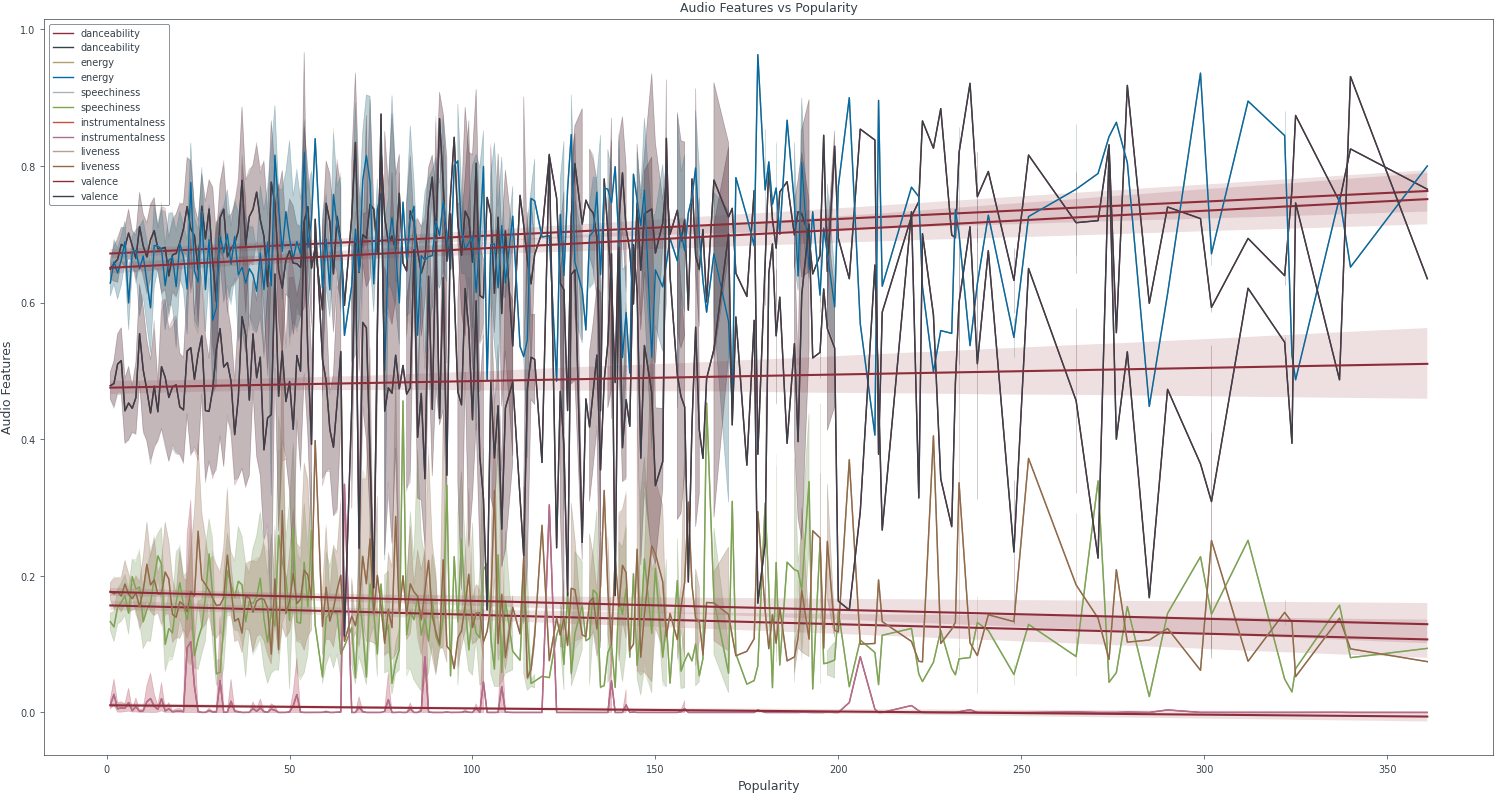

In [154]:
# Get the regional trends for Germany
german_df = get_charts_by_region(charts_df, "Germany")
weekly_trends_popularity,weekly_trends_popularity_dates = regional_delta_popularity(german_df,
                                                                                    datetime.datetime(2018,1,1).date(),
                                                                                    datetime.datetime(2018,12,31).date(),
                                                                                    delta=365,
                                                                                    top_k=200)
weekly_trends_popularity_features = [add_audio_features(df, audio_df) for df in weekly_trends_popularity]

# See the audio feature vs popularity 
# Clear the figure

plt.figure(figsize=(15, 8))
for col in interest_columns:
    sns.lineplot(x="popularity", y=col, data=weekly_trends_popularity_features[0], label=col)
    # Get a best fit line, make sure that color is the same as the line
    sns.regplot(x="popularity", y=col, data=weekly_trends_popularity_features[0], scatter=False, color=sns.lineplot(x="popularity", y=col, data=weekly_trends_popularity_features[0], label=col).get_lines()[0].get_color())
plt.title("Audio Features vs Popularity")
plt.xlabel("Popularity")
plt.ylabel("Audio Features")
plt.show()